In [70]:
# Install necessary libraries (only need to run once)
!pip install category-encoders tqdm matplotlib seaborn plotly

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")

# For progress tracking in loops
from tqdm.notebook import tqdm

In [71]:
# Load the data
file_path = '/content/bank-additional-full.csv'  # Change the file path as per your system
data = pd.read_csv(file_path, sep=';')

# Display first few rows and basic information about the data
display(data.head(3))
print(f"Number of records: {data.shape[0]}, Number of features: {data.shape[1]}")

# Check for NULL values
print(data.isnull().sum())

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Number of records: 41188, Number of features: 21
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


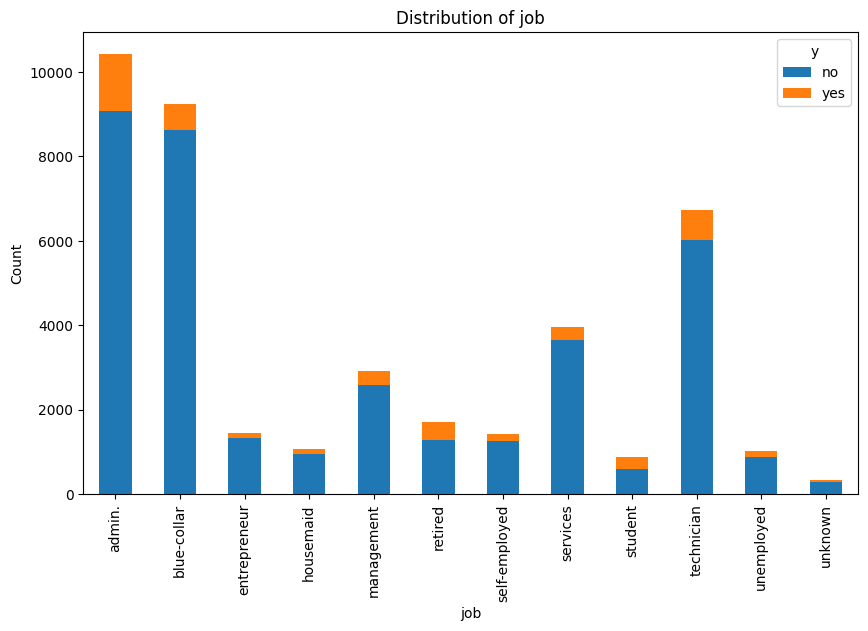

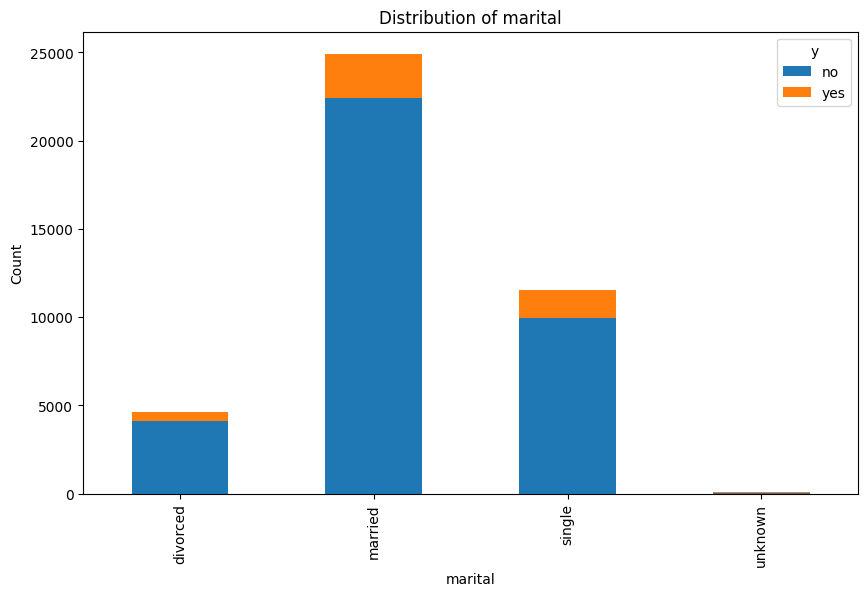

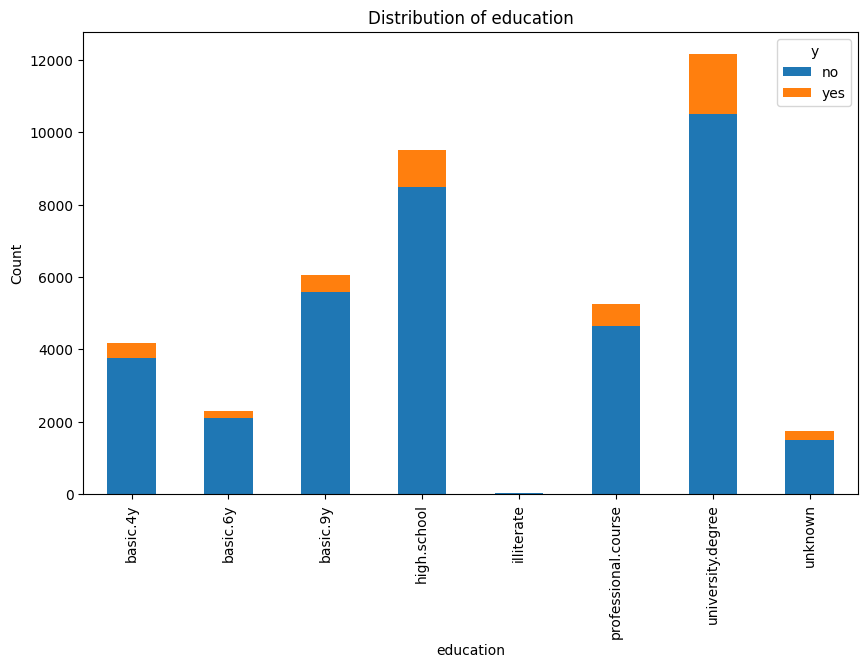

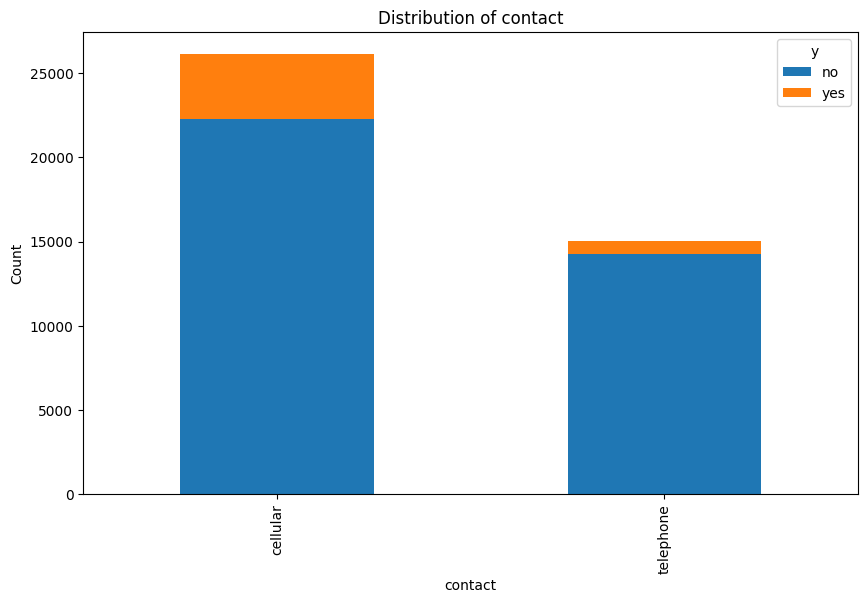

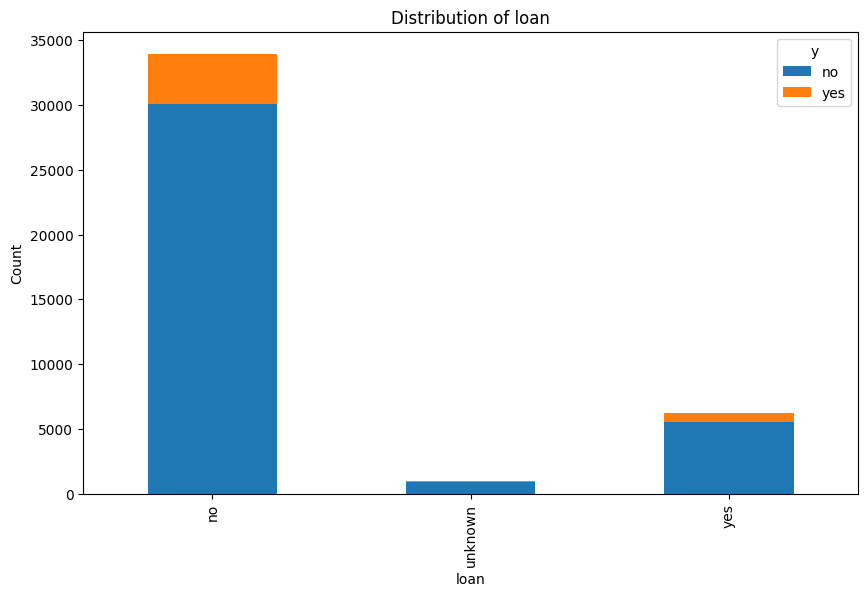

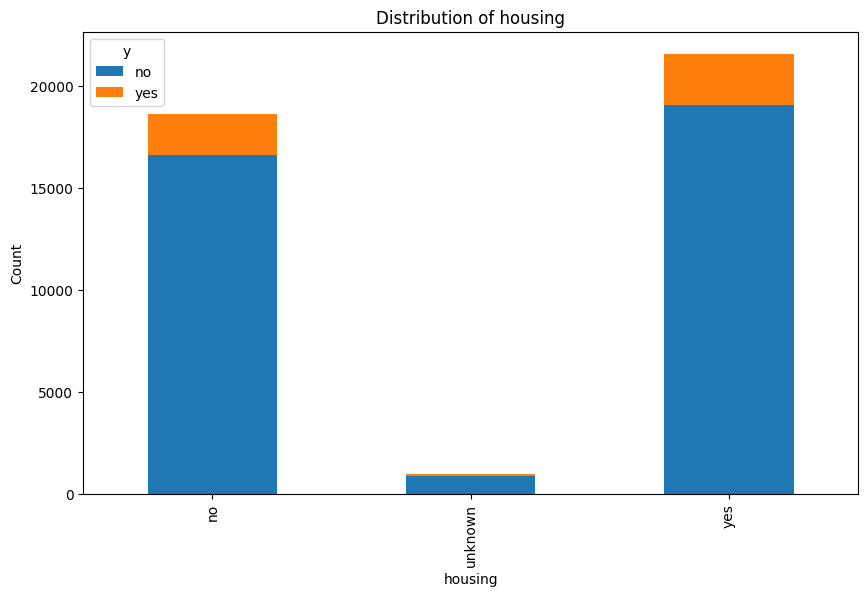

In [72]:
# Function to plot distribution of variables
def plot_bar(column, target='y'):
    temp = pd.crosstab(data[column], data[target])
    temp.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

# Plot charts for important features
categorical_columns = ['job', 'marital', 'education', 'contact', 'loan', 'housing']
for col in categorical_columns:
    plot_bar(col)

In [73]:
# Convert target variable to numeric
data['y'] = data['y'].map({'no': 0, 'yes': 1}).astype('uint8')

# Convert categorical variables to numeric
binary_mappings = {
    'contact': {'cellular': 1, 'telephone': 0},
    'loan': {'yes': 1, 'no': 0, 'unknown': 0},
    'housing': {'yes': 1, 'no': 0, 'unknown': 0},
    'default': {'yes': 0, 'no': 1, 'unknown': 0},
    'poutcome': {'nonexistent': 0, 'failure': 0, 'success': 1}
}
for col, mapping in binary_mappings.items():
    data[col] = data[col].map(mapping).astype('uint8')

In [74]:
def categorize_duration(data):
    bins = [0, 102, 180, 319, 645, np.inf]
    labels = [1, 2, 3, 4, 5]

    # Categorize duration values
    data['duration_category'] = pd.cut(data['duration'], bins=bins, labels=labels)

    # Convert to integer and replace NaN with default value (e.g., 0)
    data['duration_category'] = data['duration_category'].cat.add_categories([0]).fillna(0).astype(int).astype('uint8')

    return data

# Apply the categorization function
data = categorize_duration(data)

In [75]:
print(data['duration_category'].unique())  # Final categories
print(data['duration_category'].dtype)    # Should be 'uint8'


[3 2 4 1 5 0]
uint8


In [76]:
# Target Encoding
target_encoder = ce.TargetEncoder(cols=['marital', 'education'])
data = target_encoder.fit_transform(data, data['y'])

# One-Hot Encoding for other columns
data = pd.get_dummies(data, columns=['job', 'month', 'day_of_week'], drop_first=True)


In [77]:
# Split the data
X = data.drop(columns=['y'])
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (32950, 42), Test shape: (8238, 42)


In [78]:
# Grid Search parameters for models
grid_params = {
    'RandomForest': {
        'n_estimators': [60, 100],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5]
    },
    'LogisticRegression': {
        'penalty': ['l2'],
        'C': [0.1, 1.0]
    }
}

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Function to run Grid Search
def run_grid_search(model, params, X_train, y_train):
    grid = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=3)
    grid.fit(X_train, y_train)
    print(f"Best params: {grid.best_params_}")
    print(f"Best ROC-AUC: {grid.best_score_}")
    return grid.best_estimator_

# Run Grid Search for models
rf_model = run_grid_search(RandomForestClassifier(random_state=11), grid_params['RandomForest'], X_train, y_train)
lr_model = run_grid_search(LogisticRegression(random_state=11, max_iter=1000), grid_params['LogisticRegression'], X_train, y_train)

Best params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best ROC-AUC: 0.945017022173262
Best params: {'C': 0.1, 'penalty': 'l2'}
Best ROC-AUC: 0.9334880606081623


In [80]:
from sklearn.metrics import classification_report, roc_auc_score

# Evaluate models
for model, name in [(rf_model, 'Random Forest'), (lr_model, 'Logistic Regression')]:
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

Model: Random Forest
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7310
           1       0.65      0.52      0.58       928

    accuracy                           0.92      8238
   macro avg       0.80      0.74      0.77      8238
weighted avg       0.91      0.92      0.91      8238

ROC-AUC: 0.944
Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.65      0.44      0.53       928

    accuracy                           0.91      8238
   macro avg       0.79      0.71      0.74      8238
weighted avg       0.90      0.91      0.90      8238

ROC-AUC: 0.934
